In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from time import time
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from torchvision import transforms 
from torchvision import datasets

In [3]:
class dataset(Dataset):
  def __init__(self, x, y):
    self.x = torch.FloatTensor(x)
    self.y = torch.FloatTensor(y)
  def __len__(self):
    return len(self.x)
  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

In [4]:
class Data:
    def __init__(self, config):
        self.normal_num = config['normal_num']
        if config['experiment_num'] == 1 or config['experiment_num'] == 3:
            self.ratio = 0.1
        elif config['experiment_num'] == 2 or config['experiment_num'] == 4:
            self.ratio = 0.01
        self.train_x, self.train_y, self.test_x, self.test_y = self.load_data(config['experiment_num'])
        self.train_dataset = dataset(self.train_x, self.train_y)
        self.test_dataset = dataset(self.test_x, self.test_y)

    def load_data(self, experiment_num):
        train_dataset = datasets.MNIST(root="MNIST/processed/training.pt", train=True,  download=False)
        train_x, train_y = train_dataset.data, train_dataset.targets
        test_dataset = datasets.MNIST(root="MNIST/processed/test.pt", train=False,  download=False)
        test_x, test_y = test_dataset.data, test_dataset.targets
        if experiment_num == 3 or experiment_num == 4:
            train_x, train_y = self.agumentation10(train_x, train_y)
        train_x, train_y = self.preprocessing(x=train_x, y=train_y, normal_num=self.normal_num, abnormal_ratio=self.ratio) # abnormal_ratio=0으로 하면 train에 normal만 존재
        test_x, test_y = self.preprocessing(test_x, test_y, self.normal_num, self.ratio) 
        return train_x, train_y, test_x, test_y
  
    def agumentation10(self, x, y):
        trans_x = transforms.functional.affine(x, angle=0, translate=[0, 0], scale=1, shear=0)
        trans_y = y
        for trans in [[1, 0], [-1, 0], [0, 1], [0, -1], [1, 1], [1, -1], [-1, 1], [-1, -1], [2, 0]]:
            temp = transforms.functional.affine(x, angle=0, translate=trans, scale=1, shear=0)
            trans_x = torch.cat([trans_x, temp])
            trans_y = torch.cat([trans_y, y])
        return trans_x, trans_y

    def preprocessing(self, x, y, normal_num, abnormal_ratio):
        x = x.float()
        x = x/255.0
        #x = (x-torch.min(x))/(torch.max(x)-torch.min(x))
        #x = (x-torch.mean(x))/torch.std(x)
        N = len(x)
        processing_x = []
        processing_y = []
        for i in range(N):
            if y[i] == normal_num:
                processing_x.append(x[i].reshape(-1).tolist())
                processing_y.append([y[i].tolist()])
        num_normal_data = len(processing_x)
        print("number of normal data: {}".format(num_normal_data))
        i = 0
        while(1):
            if len(processing_x) >= num_normal_data*(1+abnormal_ratio):
                break
            if y[i] != normal_num:
                processing_x.append(x[i].reshape(-1).tolist())
                processing_y.append([y[i].tolist()])
            i += 1
        print("number of abnormal data: {}".format(len(processing_x)-num_normal_data))
        return processing_x, processing_y

In [5]:
class ModelWrapper:
    def __init__(self, model, data, config):
        self.model = model
        self.batch_size = config['batch_size']
        self.normal_num = config['normal_num']
        self.data = data
        self.train_data = self.data.train_dataset
        self.test_data = self.data.test_dataset
        self.train_loader = DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True)
        self.test_loader = DataLoader(self.test_data, batch_size=1, shuffle=False)
    
    def train(self):
        start = time()
        self.model.fit(data.train_x)
        print('Time spent on training:', time()-start)
    
    def predict(self, test_x, test_y):
        scores = self.model.score_samples(test_x)
        true = np.where(np.array(test_y) == config['normal_num'], 0, 1) #정상 0, 비정상1
        
        pair_list = [(t, p) for t, p in zip(true, scores)]
        pair_list = sorted(pair_list, key=lambda x: x[0])

        true_list = []
        pred_list = []

        for t, p in pair_list:
            true_list.append(t)
            pred_list.append(p)

        return true_list, pred_list



In [6]:
config = {
    "normal_num": 0,
    "experiment_num": 1,
    "batch_size": 1024,
}

In [7]:
data = Data(config)

number of normal data: 5923
number of abnormal data: 593
number of normal data: 980
number of abnormal data: 98


In [8]:
auc_list = []
nu_list = [0.01, 0.03, 0.1, 0.3, 0.5, 0.7]

for nu in nu_list:
    model = OneClassSVM(kernel='rbf', gamma=0.001, nu=nu)
    engine = ModelWrapper(model, data, config)
    engine.train()
    true_y, pred_y = engine.predict(data.test_x, data.test_y)
    pred_y = list(np.array(pred_y)*(-1))
    print('nu:', nu, 'AUC:', roc_auc_score(true_y, pred_y))
    auc_list.append(roc_auc_score(true_y, pred_y))
    print()

idx = auc_list.index(max(auc_list))
best_nu = nu_list[idx]
print('Best nu:', best_nu)

Time spent on training: 1.3095567226409912
nu: 0.01 AUC: 0.8925655976676385

Time spent on training: 3.132737636566162
nu: 0.03 AUC: 0.8883277800916285

Time spent on training: 9.52063250541687
nu: 0.1 AUC: 0.8935860058309038

Time spent on training: 25.460254669189453
nu: 0.3 AUC: 0.9091107871720115

Time spent on training: 36.99309802055359
nu: 0.5 AUC: 0.9355685131195335

Time spent on training: 44.09723973274231
nu: 0.7 AUC: 0.9443565181174511

Best nu: 0.7


In [9]:
model = OneClassSVM(kernel='rbf', gamma=0.001, nu=best_nu)
engine = ModelWrapper(model, data, config)
engine.train()

Time spent on training: 44.11904978752136


In [10]:
true_y, pred_y = engine.predict(data.test_x, data.test_y)
pred_y = list(np.array(pred_y)*(-1))
fpr, tpr, threshold = roc_curve(true_y, pred_y, pos_label=1)

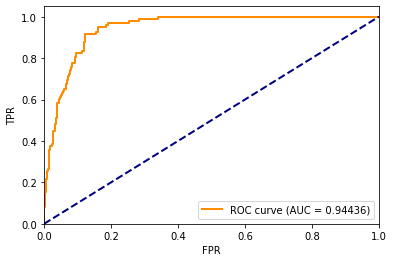

In [11]:
# 실험 1 기준
# (1) x/255 전처리 방식 auc: 0.94436
# (2) max_min 전처리 방식 auc: 0.94436
# (3) standardization 전처리 방식 auc: 0.95533
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {})'.format(round(auc(fpr, tpr), 5)))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc="lower right")
plt.show()

In [12]:
def select_threshold(fpr, tpr, threshold):
  ret = 0
  standard = (0, 1)
  threshold_distance = 9999999999
  for x, y, th in zip(fpr, tpr, threshold):
    distance = (x-standard[0])**2+(y-standard[1])**2
    if distance < threshold_distance:
      threshold_distance = distance
      ret = th
  return ret

In [13]:
#0 은 정상, 1은 비정상
true_list = []
pred_list = []
test_x = data.test_x
test_y = data.test_y
my_threshold = select_threshold(fpr, tpr, threshold)

scores = model.score_samples(test_x) * (-1)
pred_list = np.where(scores < my_threshold, 0, 1)
true_list = np.where(np.array(test_y) == config['normal_num'], 0, 1)

In [14]:
print(my_threshold)
print(confusion_matrix(true_list, pred_list))
print(classification_report(true_list, pred_list))
idx = 0
fp_list = []
fn_list = []
for t, p in zip(true_list, pred_list):
  if t == 0 and p == 1:
    fp_list.append(idx)
  if t == 1 and p == 0:
    fn_list.append(idx)
  idx +=1

-4057.5033233309787
[[861 119]
 [  8  90]]
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       980
           1       0.43      0.92      0.59        98

    accuracy                           0.88      1078
   macro avg       0.71      0.90      0.76      1078
weighted avg       0.94      0.88      0.90      1078



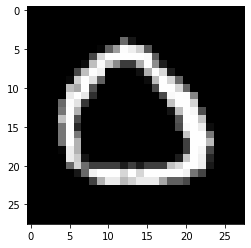

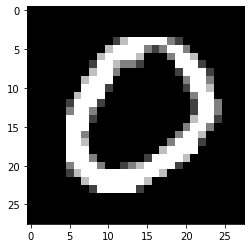

In [15]:
# FP -> 실제 0 인데, 0이 아니라고 예측한 상황
for idx in fp_list[:2]:
  x = data.test_x[idx]
  x = torch.FloatTensor(x)
  image_origin = np.array(np.array(data.test_x[idx]).reshape(28, 28)*255, dtype=int)
  plt.imshow(image_origin, cmap='gray')
  plt.show()
  print()

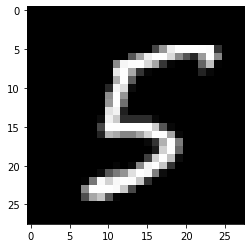

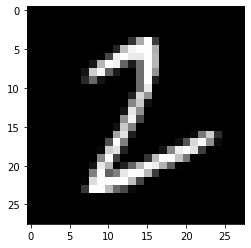

In [16]:
# FN -> 실제 0 아닌데, 0이라고 예측한 상황
for idx in fn_list[:2]:
  x = data.test_x[idx]
  x = torch.FloatTensor(x)
  image_origin = np.array(np.array(data.test_x[idx]).reshape(28, 28)*255, dtype=int)
  plt.imshow(image_origin, cmap='gray')
  plt.show()
  print()